In [75]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels import api
from scipy import stats
from scipy.optimize import minimize 
import json
import pprint


In [152]:
# This function cleans the data and creates c_0, c_f, and log_c_f

def cleanData(df):
    # Remove unnecessary columns
    df = df.drop('Link', axis=1)
    df = df[df['Cited by'] > 0]
    df['c_0'] = 0


    # Calc c_0      
    c_0 = {
        2010: df.loc[df['Year'] == 2010, 'Cited by'].mean(),
        2011: df.loc[df['Year'] == 2011, 'Cited by'].mean(),
        2012: df.loc[df['Year'] == 2012, 'Cited by'].mean(),
        2013: df.loc[df['Year'] == 2013, 'Cited by'].mean(),
        2014: df.loc[df['Year'] == 2014, 'Cited by'].mean(),
        2015: df.loc[df['Year'] == 2015, 'Cited by'].mean()
    }
    for index, row in df.iterrows():
        df['c_0'][index] = c_0[row['Year']]
  
    # Calc c_f
    df['c_f'] = df['Cited by'] / df['c_0']

    df['log_c_f'] = np.log(df['c_f'])

    return df




In [159]:
# This function defines the log-likelihood function that is used in the optimisation

def get_opti_fun(df):
   # MLE function
   def MLE_Norm(parameters):
      # extract parameters
      mu, sigma = parameters
      # Calculate the log-likelihood for normal distribution
      LL = np.sum(stats.norm.logpdf(df['log_c_f'], loc=mu, scale=sigma))
      # Calculate the negative log-likelihood
      neg_LL = -1*LL
      return neg_LL
   return MLE_Norm

In [160]:
# Load data sets

ai_ml = pd.read_csv('AI_ML.csv')
com_net = pd.read_csv('Communications_Networking.csv')
con_alg = pd.read_csv('ControlSystems_Algorithms.csv')
edge_com = pd.read_csv('EdgeComputing.csv')
loc_map = pd.read_csv('Localisation_Mapping.csv')
rob = pd.read_csv('Robotics.csv')
sen_fus = pd.read_csv('sensor_fusion.csv')
sen_tec = pd.read_csv('sensor_technology.csv')
sim_mod = pd.read_csv('Simulation_Modeling.csv')
swarm_mult = pd.read_csv('Swarming_MultiAgent.csv')

dataSets = [ai_ml, com_net, con_alg, edge_com, loc_map, rob, sen_fus, sen_tec, sim_mod, swarm_mult]

In [161]:
# Function that performs the maximum likelihood-estimation. Outputs a dict of parameters for each technology

def MLE_estimation(dataSets):

    parameterDict = {}
    key_names = ["ai_ml", "com_net", "con_alg", "edge_com", "loc_map", "rob", "sen_fus", "sen_tec", "sim_mod", "swarm_mult"]
    initParams = [1,1]
    
    for index, df in enumerate(dataSets):
        df = cleanData(df)

        mle = minimize(get_opti_fun(df), initParams, method='Nelder-Mead')
        mu = mle.x[0]
        sigma = mle.x[1]
        parameterDict.update({key_names[index]: {'mu': mu}})
        parameterDict[key_names[index]].update({'sigma': sigma})

    return parameterDict

        

In [162]:
# Perform the estimation

parameters = MLE_estimation(dataSets)

/var/folders/9r/w8p_5y0s0913xqcffg4y86sr0000gn/T/ipykernel_7681/1253599995.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['c_0'][index] = c_0[row['Year']]
/var/folders/9r/w8p_5y0s0913xqcffg4y86sr0000gn/T/ipykernel_7681/1253599995.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['c_0'][index] = c_0[row['Year']]
/var/folders/9r/w8p_5y0s0913xqcffg4y86sr0000gn/T/ipykernel_7681/1253599995.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

In [163]:
with open("distribution_params.json", "w") as write_file:
    json.dump(parameters, write_file, indent=4)

In [164]:
parameters

{'ai_ml': {'mu': -0.386351113101974, 'sigma': 0.644401741347951},
 'com_net': {'mu': -0.29729339876492644, 'sigma': 0.6389827943670707},
 'con_alg': {'mu': -0.3119378754147418, 'sigma': 0.6769543590139491},
 'edge_com': {'mu': -0.4382650698614001, 'sigma': 0.7444251571378885},
 'loc_map': {'mu': -0.3003677245964875, 'sigma': 0.6310363643099357},
 'rob': {'mu': -0.28433042470183617, 'sigma': 0.6002492792460522},
 'sen_fus': {'mu': -1.081137272906017, 'sigma': 1.3830866052163735},
 'sen_tec': {'mu': -0.9657359048121048, 'sigma': 1.3653131476411307},
 'sim_mod': {'mu': -0.225569901458396, 'sigma': 0.528705539762359},
 'swarm_mult': {'mu': -0.5216991391810393, 'sigma': 0.8769489580459121}}

In [165]:
def plot_dist(dataSets, parameters=parameters):
    
    key_names = ["ai_ml", "com_net", "con_alg", "edge_com", "loc_map", "rob", "sen_fus", "sen_tec", "sim_mod", "swarm_mult"]

    for index, df in enumerate(dataSets):
        mu = parameters[key_names[index]]["mu"]
        sigma = parameters[key_names[index]]["sigma"]
        dist = stats.lognorm([sigma], loc=mu)
        x = np.linspace(0,100,1000)
        plt.xlabel("c_f")
        plt.ylabel("P(c|c_0)")
        plt.legend(key_names, )
        plt.xscale("log")
        plt.yscale("log")
        plt.plot(x,dist.pdf(x))

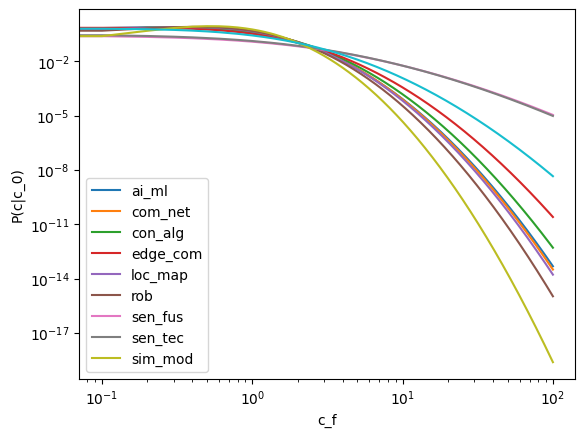

In [166]:
plot_dist(dataSets)